<a href="https://colab.research.google.com/github/RQC-Robotics/PointClouds/blob/main/PC_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

mujoco_dir = "$HOME/.mujoco"

print('Installing OpenGL dependencies...')
!apt-get update -qq
!apt-get install -qq -y --no-install-recommends libglew2.0 > /dev/null

print('Downloading MuJoCo...')
MUJOCO_VERSION = 210
MUJOCO_ARCHIVE = (
    f'mujoco{MUJOCO_VERSION}-{distutils.util.get_platform()}.tar.gz')
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}"
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}.sha256"
check_result = !shasum -c "{MUJOCO_ARCHIVE}.sha256"
if _exit_code:
  raise RuntimeError(
      'Downloaded MuJoCo archive is corrupted (checksum mismatch)')

print('Unpacking MuJoCo...')
MUJOCO_DIR = '$HOME/.mujoco'
!mkdir -p "{MUJOCO_DIR}"
!tar -zxf {MUJOCO_ARCHIVE} -C "{MUJOCO_DIR}"

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Installing dm_control...')
!pip install -q dm_control

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, env, pixels

Installing OpenGL dependencies...
Unpacking MuJoCo...
env: MUJOCO_GL=egl
Installing dm_control...
     |████████████████████████████████| 38.6 MB 1.3 MB/s 
     |████████████████████████████████| 205 kB 50.6 MB/s 
     |████████████████████████████████| 4.9 MB 42.5 MB/s 
Checking that the dm_control installation succeeded...


In [7]:
!ls ~/.mujoco -al

total 16
drwxr-xr-x 3 root   root  4096 Nov 30 11:36 .
drwx------ 1 root   root  4096 Nov 30 11:36 ..
drwxr-xr-x 6 421709 89939 4096 Oct  7 18:12 mujoco210


In [8]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [9]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [11]:
#@title Iterating over tasks{vertical-output: true}

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
  print(f'{domain:<{max_len}}  {task}')

acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run


In [13]:
# Load the environment
random_state = np.random.RandomState(42)
env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})

In [19]:
env.step([1, 1, 1, 1])

TimeStep(step_type=<StepType.MID: 1>, reward=0.8, discount=1.0, observation=OrderedDict([('position', array([-0.00266468, -0.82613712,  0.49368605, -0.63726425,  1.620374  ,
       -0.52952705])), ('velocity', array([ 0.06558366, -0.21420261, -3.0238329 ,  1.73460378,  2.41436523,
        1.43743292,  0.86446789])), ('touch', array([0., 0.]))]))

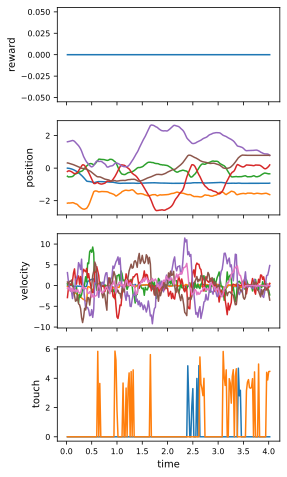

In [20]:
#@title Loading and simulating a `suite` task{vertical-output: true}


# Simulate episode with random actions
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:

  action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
  time_step = env.step(action)

  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  rewards.append(time_step.reward)
  observations.append(copy.deepcopy(time_step.observation))
  ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)

html_video

In [23]:
from dm_control.mujoco import cymj
from mujoco import load_model_from_path, MjSim
#from mj_point_clouds import PointCloudGenerator
import open3d as o3d

# model = load_model_from_path("path_to_your_model_with_cameras")
# sim = MjSim(model)
# Bounds can optionally be provided to crop points outside the workspace
pc_gen = PointCloudGenerator(env.sim, min_bound=(-1., -1., -1.), max_bound=(1., 1., 1.))
cloud_with_normals = pc_gen.generateCroppedPointCloud(save_img_dir='./')
print(cloud_with_normals)
world_origin_axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
o3d.visualization.draw_geometries([cloud_with_normals])#, world_origin_axes])

ImportError: ignored

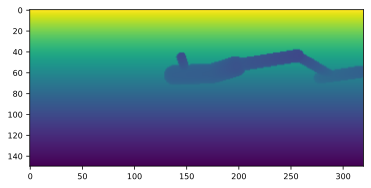

In [40]:
plt.imshow(env.physics.render(depth=True)[50:200])

In [34]:
env.physics.render(depth=True).shape

(240, 320)

In [35]:
env.physics.render(depth=False).shape

(240, 320, 3)

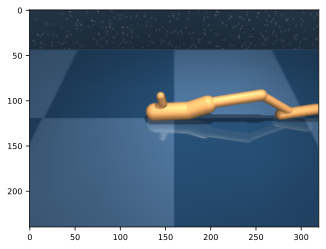

In [36]:
plt.imshow(env.physics.render(depth=False))

In [49]:
env.physics.model.cam_quat

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.60846234,  0.47731713, -0.39130645, -0.4988198 ]])

In [50]:
env.physics.model.cam_mat0

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.22044605e-16, -1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  2.22044605e-16],
       [ 1.96116135e-01,  2.33471589e-01, -9.52380952e-01,
        -9.80580676e-01,  4.66943179e-02, -1.90476190e-01,
         1.11022302e-16,  9.71241812e-01,  2.38095238e-01]])